# Классификатор Xception Network, реализованный на Keras и Tensorflow и обученный на датасете CIFAR.

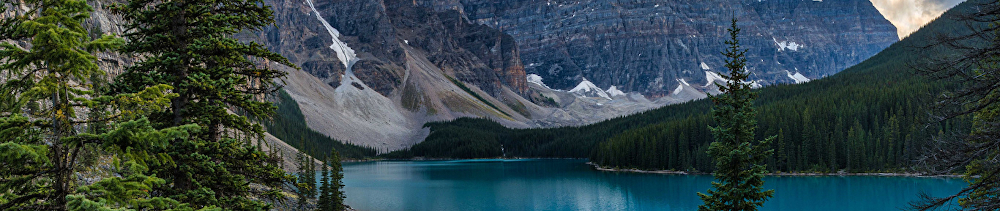

Может различать маленькие картинки 32х32 с самолётами, автомобилями, птицами, кошками, оленями, собаками, лягушками, лошадьми, кораблями и грузовиками.

Несколько ячеек ниже: для скачивания и распаковки датасета в Colab в окружении на основе Linux.

Эти же ячейки можно выполнить на Windows, если необходимые утилиты (rm, ls, curl, tar и пр.) будут установлены с помощью [Cygwin](https://cygwin.com/install.html).

In [ ]:
# Очищаем workspace от сохранённых обученных моделей от предыдущих запусков.
#!rm -rf xception_network_cifar_10_checkpoints/
#!rm -rf xception_network_cifar_10/

In [ ]:
# Очищаем workspace от распакованного датасета от предыдущих запусков.
!rm -rf cifar_10/

In [ ]:
# Сколько файлов в каждой выборке.
!find cifar_10/train | wc -l
!find cifar_10/validation | wc -l
!find cifar_10/test | wc -l

Завершили скачивание и подготовку датасета. Это можно сделать либо ячейками выше, либо вручную.

In [ ]:
import tensorflow as tf

In [ ]:
# Параметры.
SEED = 1337
IMAGE_SIZE = (32, 32)
# Элементов, не байт.
BATCH_SIZE = 32

In [ ]:
# Генерируем обучающую и валидационную выборки.

train_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "cifar_10/train",
    label_mode = "categorical",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

validation_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "cifar_10/validation",
    label_mode = "categorical",
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

In [ ]:
# Посмотрим на изображения.
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_images.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Буферизируем ввод.
# Размер буфера (кол-во элементов, не байт) делаем равным размеру батча, который использовался 
train_images = train_images.prefetch(buffer_size=BATCH_SIZE)
validation_images = validation_images.prefetch(buffer_size=BATCH_SIZE)

In [ ]:
# Метод для создания модели Xception network.
def build_xception_network(input_shape, num_classes):
    inputs = tf.keras.Input(shape = input_shape)

    # Наращивание можно сделать частью архитектуры нейронной сети.
    #x = augmentation_network(inputs)

    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)

In [ ]:
# Создаём модель.
xception_network_cifar_10 = build_xception_network(input_shape = IMAGE_SIZE + (3,), num_classes = 10)

In [ ]:
# Визуализируем её.
tf.keras.utils.plot_model(xception_network_cifar_10, show_shapes = True)

In [ ]:
# Либо обучаем нейронную сеть.
# (!) Долгий процесс.
EPOCHS = 50

# callback для сохранения результатов обучения в формате Keras (h5) после каждой эпохи обучения.
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/xception_network_cifar_10_checkpoints/epoch_{epoch}.h5")
]
xception_network_cifar_10.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
xception_network_cifar_10.fit(
    train_images, epochs=EPOCHS, callbacks=callbacks, validation_data=validation_images
)
# Сохраняем модель целиком в формате TensorFlow (saved_model.pb + variables/).
xception_network_cifar_10.save("drive/MyDrive/xception_network_cifar_10");

In [ ]:
# Либо загружаем весовые коэффециенты от заранее обученной модели в формате Keras (h5).
xception_network_cifar_10.load_weights('drive/MyDrive/xception_network_cifar_10_checkpoints/epoch_50.h5')

In [ ]:
# Либо загружаем заранее обученную модель целиком из формата TensorFlow (saved_model.pb + variables/).
xception_network_cifar_10 = tf.keras.models.load_model("drive/MyDrive/xception_network_cifar_10")

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "cifar_10/test/b_airplane__0/b_airplane__0_10200.jpg", target_size=IMAGE_SIZE
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = xception_network_cifar_10.predict(img_array)
airplane_score = predictions[0][0]
automobile_score = predictions[0][1]
bird_score = predictions[0][2]
cat_score = predictions[0][3]
deer_score = predictions[0][4]
dog_score = predictions[0][5]
frog_score = predictions[0][6]
horse_score = predictions[0][7]
ship_score = predictions[0][8]
truck_score = predictions[0][9]
print(f"Score: {predictions}")
print(
    "С вероятностью %.2f процентов на картинке изображен самолёт,\nс вероятностью %.2f процентов - автомобиль,\nс вероятностью %.2f процентов - птица,\nс вероятностью %.2f процентов - кошка,\nс вероятностью %.2f процентов - олень,\nс вероятностью %.2f процентов - собака,\nс вероятностью %.2f процентов - лягушка,\nс вероятностью %.2f процентов - лошадь,\nс вероятностью %.2f процентов - корабль,\nс вероятностью %.2f процентов - грузовик." %
    (100 * airplane_score,
    100 * automobile_score,
    100 * bird_score,
    100 * cat_score,
    100 * deer_score,
    100 * dog_score,
    100 * frog_score,
    100 * horse_score,
    100 * ship_score,
    100 * truck_score)
)

plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis("off")

In [ ]:
# Генерация примера ответов. Ответы модели.
import numpy as np
import pandas as pd

class_index_to_label = [
    "AIRPLANE",
    "AUTOMOBILE",
    "BIRD",
    "CAT",
    "DEER",
    "DOG",
    "FROG",
    "HORSE",
    "SHIP",
    "TRUCK"
]

answer_key = pd.read_csv('sample_submision.csv')
answers = pd.DataFrame()
for id in answer_key['Id']:
    img = tf.keras.preprocessing.image.load_img(
        f"cifar_10/test/{id}.jpg", target_size=IMAGE_SIZE
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = xception_network_cifar_10.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    answers = answers.append({'Id': id, 'Category': class_index_to_label[predicted_class_index]}, ignore_index=True)

answers = answers.set_index(keys = 'Id')
answers.index = answers.index.astype(int)
answers.to_csv('model_answers.csv')